### *En el siguiente documento se lleva a cabo la exploracion de los datos, y del modelo de machine learning*

1.0 Importacion de librerias

In [49]:
import pandas as pd
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import numpy as np
from collections import Counter
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV


1.1 Configuracions

In [2]:
warnings.filterwarnings("ignore")

1.2 importacion del dataset

*En el entorno real el dataset deberia descargarse de GCS en formato parquet y unirse con el analisis de sentimiento ya realizado y guardado en local*

In [3]:
modelo=pd.read_csv(r'C:\Users\ruizr\Desktop\datos\data_limpia\final.csv')

In [4]:
modelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5358 entries, 0 to 5357
Data columns (total 83 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  5358 non-null   int64  
 1   business_id                 5358 non-null   int64  
 2   business_name               5358 non-null   object 
 3   address                     5358 non-null   object 
 4   county_id                   5358 non-null   int64  
 5   latitude                    5358 non-null   float64
 6   longitude                   5358 non-null   float64
 7   AcceptsInsurance            5358 non-null   int64  
 8   AgesAllowed                 5358 non-null   int64  
 9   Alcohol                     5358 non-null   int64  
 10  ambience_romantic           5358 non-null   int64  
 11  ambience_intimate           5358 non-null   int64  
 12  ambience_classy             5358 non-null   int64  
 13  ambience_hipster            5358 

2.2 Creacion de las metricas necesarias para definir la variable exito

- *Contar total de reseñas por negocio*

In [5]:
resenas_totales = modelo.groupby('business_id')['text_review'].count()

In [6]:
resenas_totales.max()

np.int64(475)

- *Contar reseñas positivas por negocio*

In [7]:
resenas_positivas = modelo[modelo['positive_sentiment'] == 1].groupby('business_id')['text_review'].count()

In [8]:
resenas_positivas.max()


np.int64(458)

- *Calcular porcentaje de reseñas positivas*

In [9]:
porcentaje_positivas = (resenas_positivas / resenas_totales).fillna(0)

In [10]:
porcentaje_positivas

business_id
1      0.600000
2      0.621622
3      0.444444
4      0.500000
5      0.705882
         ...   
254    1.000000
255    1.000000
256    1.000000
257    1.000000
258    0.500000
Name: text_review, Length: 258, dtype: float64

- *Crear una columna auxiliar con el porcentaje*

In [10]:
modelo['porcentaje_positivas'] = modelo['business_id'].map(porcentaje_positivas)

### *Definicion de la variable "exito"*

In [11]:
modelo['exito'] = (
    (modelo['stars'] >= 4.5) &
    (modelo['business_id'].map(resenas_totales) > 100)
   ).astype(int)

- Se generan nuevas variables a partir de metricas entre otras columnas 

In [12]:
modelo['locales_en_condado'] = modelo.groupby('county_id')['business_id'].transform('count')


In [13]:
modelo['locales_por_1000hab'] = (modelo['locales_en_condado'] / modelo['poblacion_total']) * 1000


In [14]:
modelo['prom_stars_condado'] = modelo.groupby('county_id')['stars'].transform('mean')


In [15]:
resenas_por_condado = modelo.groupby('county_id')['text_review'].count()
modelo['prom_resenas_condado'] = modelo['county_id'].map(resenas_por_condado / modelo['locales_en_condado'])


In [16]:
resenas_por_condado.max()

np.int64(501)

In [17]:
modelo['porc_positivas_condado'] = modelo.groupby('county_id')['positive_sentiment'].transform('mean')


In [18]:
modelo['porc_positivas_condado']

0       0.533333
1       0.533333
2       0.533333
3       0.533333
4       0.533333
          ...   
5353    0.457627
5354    0.518987
5355    0.518987
5356    0.666667
5357    0.666667
Name: porc_positivas_condado, Length: 5358, dtype: float64

### *Mediante graficos se busca visualizar aquellas variables que tenen mas correlacion con la variable objetivo 'EXITO'*

In [ ]:
# Filtrarcolumnas numéricas
numericas = modelo.select_dtypes(include=['int64', 'float64'])

# matriz de correlación
correlacion = numericas.corr()

# extraer solo la correlación con la variable objetivo 'exito'
correlacion_exito = correlacion['exito'].drop('exito').sort_values(ascending=False)

# mostrar como tabla en porcentaje
tabla_correlacion = correlacion_exito.to_frame().reset_index()
tabla_correlacion.columns = ['Variable', 'Correlación con Éxito']
tabla_correlacion['Correlación con Éxito (%)'] = (tabla_correlacion['Correlación con Éxito'] * 100).round(2)

# top 20 más correlacionadas
print(" Variables más correlacionadas con ÉXITO (%):")
print(tabla_correlacion.head(20).to_string(index=False))


 Variables más correlacionadas con ÉXITO (%):
              Variable  Correlación con Éxito  Correlación con Éxito (%)
    locales_en_condado               0.711592                      71.16
  prom_resenas_condado               0.710315                      71.03
    prom_stars_condado               0.549834                      54.98
porc_positivas_condado               0.518512                      51.85
  porcentaje_positivas               0.445363                      44.54
                 stars               0.432632                      43.26
           GoodForKids               0.330384                      33.04
           AgesAllowed               0.284786                      28.48
                Caters               0.273137                      27.31
           meal_dinner               0.258829                      25.88
              music_dj               0.256271                      25.63
    positive_sentiment               0.252165                      25.22
     

Correlación de las variables numéricas con 'exito':

exito                     1.000000
locales_en_condado        0.711592
prom_resenas_condado      0.710315
prom_stars_condado        0.549834
porc_positivas_condado    0.518512
porcentaje_positivas      0.445363
stars                     0.432632
GoodForKids               0.330384
AgesAllowed               0.284786
Caters                    0.273137
meal_dinner               0.258829
music_dj                  0.256271
positive_sentiment        0.252165
meal_lunch                0.248649
ambience_divey            0.245284
dietary_gluten_free       0.234389
RestaurantsDelivery       0.231283
OutdoorSeating            0.216468
Alcohol                   0.212769
meal_breakfast            0.211623
bestnight_friday          0.206195
CoatCheck                 0.205020
bestnight_saturday        0.203367
GoodForDancing            0.189226
ambience_trendy           0.187674
meal_latenight            0.186594
RestaurantsAttire         0.175026
la

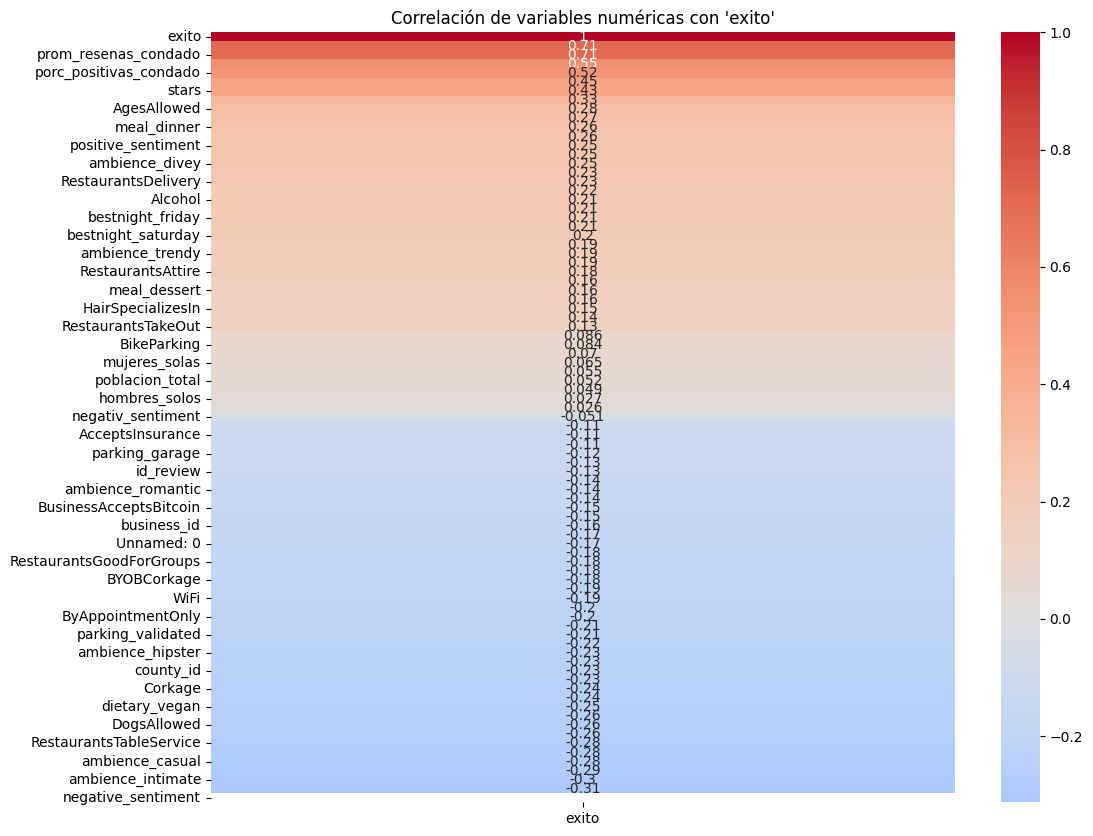

In [20]:
numericas = modelo.select_dtypes(include=['int64', 'float64'])
correlacion = numericas.corr()
correlacion_exito = correlacion['exito'].sort_values(ascending=False)

# Correlaciones más relevantes
print("Correlación de las variables numéricas con 'exito':\n")
print(correlacion_exito.head(30))
# heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlacion[['exito']].sort_values(by='exito', ascending=False), 
            annot=True, cmap="coolwarm", center=0)

plt.title("Correlación de variables numéricas con 'exito'")
plt.show()


- *Se utilizara RandomForestClassifier para seleccionar las columnas realmente correlacinadas con "Exito"*

- *Se excluyen conlumnas de tipo object*

In [21]:
columnas_a_excluir =['Unnamed: 0','business_id','id','id_review','business_name','address','county','county_id','review_date','text_review','exito']
X = modelo.drop(columns=columnas_a_excluir)
y = modelo['exito']


- *Se separan los datos para entrenar , y testear*

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


- *Se inicializa el modelo*

In [23]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

importancias = pd.Series(rf.feature_importances_, index=X.columns)
- Convierte el array de importancias en una serie de pandas, asignándole como índice los nombres de las columnas de X (las variables predictoras).
- Esto permite visualizar la importancia de cada característica de manera estructurada.

rf.feature_importances_:
- Este atributo de RandomForestClassifier devuelve un array con la importancia relativa de cada característica utilizada en el modelo.
- En esencia, indica qué variables tienen más peso en la toma de decisiones del modelo.


In [24]:
importancias = pd.Series(rf.feature_importances_, index=X.columns)
importancias = importancias.sort_values(ascending=False)


- *Se grafica*

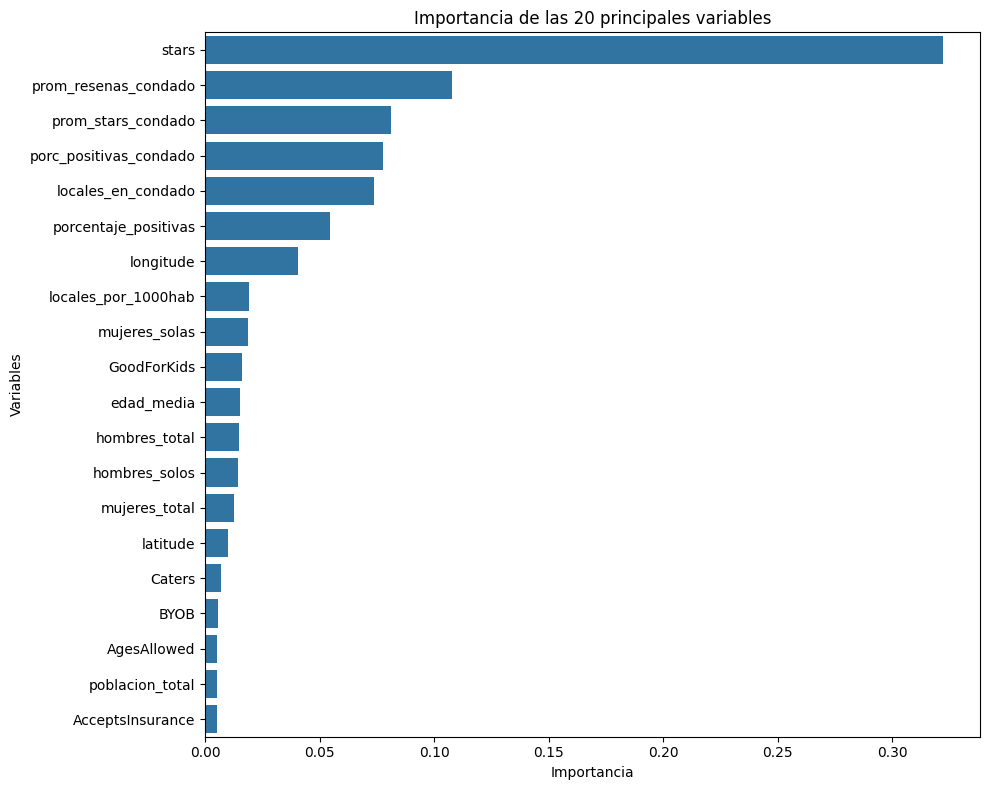

In [25]:
plt.figure(figsize=(10, 8))
sns.barplot(x=importancias[:20], y=importancias.index[:20])
plt.title("Importancia de las 20 principales variables")
plt.xlabel("Importancia")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()


### *Creacion del df con las features del modelo*

-se toman solo las variables mas relacionadas con la variable exito , excluyendo: "Stars" y porcentaje_positivas, ya que influyen en la creacion de la variable de salida " exito"

In [26]:
X = modelo[[
    'latitude', 'longitude','locales_en_condado','prom_resenas_condado','mujeres_total','porc_positivas_condado',
    'hombres_solos','hombres_total','GoodForKids','HasTV','edad_media', 'locales_por_1000hab','poblacion_total', 'prom_stars_condado','Caters'
]]
y = modelo['exito']


- *Se han analizado varias veces los modelos y se ha mejorado la precision de un 63 a un 72% en busca de llegar a un minimo de 86% se seleccionan solo las variables mas representativas*

- Se mide la importancia de las variables que se habian elegido para el entrenamiento de los modelos usando randomForest

                   Feature  Importancia
3     prom_resenas_condado     0.231475
2       locales_en_condado     0.229407
5   porc_positivas_condado     0.140316
1                longitude     0.095314
8              GoodForKids     0.072941
13      prom_stars_condado     0.069938
0                 latitude     0.030480
11     locales_por_1000hab     0.030446
4            mujeres_total     0.023106
7            hombres_total     0.021087
12         poblacion_total     0.015809
14                  Caters     0.011804
10              edad_media     0.011744
6            hombres_solos     0.009581
9                    HasTV     0.006551


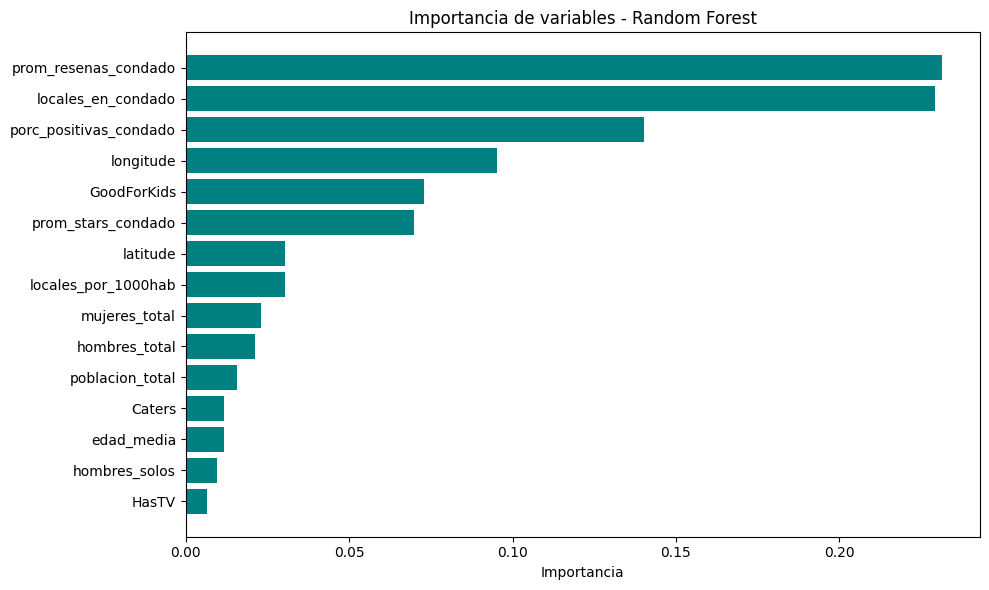

In [ ]:
X = modelo[[
 'latitude', 'longitude','locales_en_condado','prom_resenas_condado','mujeres_total','porc_positivas_condado',
    'hombres_solos','hombres_total','GoodForKids','HasTV','edad_media', 'locales_por_1000hab','poblacion_total', 'prom_stars_condado','Caters'
]]
y = modelo['exito']

# Entrenar modelo base
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X, y)

# Obtener importancias
importancias = rf.feature_importances_
features = X.columns

# Mostrar en DataFrame ordenado
importancia_df = pd.DataFrame({'Feature': features, 'Importancia': importancias})
importancia_df = importancia_df.sort_values(by='Importancia', ascending=False)
print(importancia_df)

plt.figure(figsize=(10, 6))
plt.barh(importancia_df['Feature'], importancia_df['Importancia'], color='teal')
plt.xlabel("Importancia")
plt.title("Importancia de variables - Random Forest")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Se establecen nuevamente las features para los modelos

In [28]:
X = modelo[[
    'latitude', 'longitude','locales_en_condado','prom_resenas_condado','mujeres_total','porc_positivas_condado','hombres_total',
    'GoodForKids','edad_media', 'locales_por_1000hab','poblacion_total', 'prom_stars_condado','Caters'
]]
y = modelo['exito']


- *Hay una gran desproporcion en el dataset, 0.88 de los casos son negativos y 12 positivos, sn muy pocos casos para lograr entrenar al modelo*.

### *se trabajara para balancear las clases*


In [60]:
features=modelo[[
    'latitude', 'longitude','locales_en_condado','prom_resenas_condado','mujeres_total','porc_positivas_condado','hombres_total',
    'GoodForKids','edad_media', 'locales_por_1000hab','poblacion_total', 'prom_stars_condado','Caters','exito'
]]

In [61]:
features.to_csv(r'C:\Users\ruizr\Desktop\datos\data_limpia\features.csv')

In [29]:
print(modelo["exito"].value_counts(normalize=True))


exito
0    0.879433
1    0.120567
Name: proportion, dtype: float64


- *Separacion de los datos para entrenamiento y testeo*

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Se probaran 3 modelos y se van a evaluar para decidir el mejor 

- Normalizamos las variables con StandardScaler

In [31]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

- *1° LogisticRegression*

In [32]:
log_model = LogisticRegression(class_weight='balanced', max_iter=1000)
log_model.fit(X_train_scaled, y_train)
y_pred_log = log_model.predict(X_test_scaled)
y_proba_log = log_model.predict_proba(X_test_scaled)[:, 1]


- *2° RandomForestClassifier*

In [33]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]


- *3° XGBClassifier*

In [53]:
xgb_model = XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]


*Evaluacion de los modelos*

In [35]:
def evaluar_modelo(y_test, y_pred, y_proba, nombre):
    print(f" Resultados para {nombre}")
    print(classification_report(y_test, y_pred_log))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("-" * 50)

evaluar_modelo(y_test, y_pred_log, y_proba_log, "Regresión Logística")
evaluar_modelo(y_test, y_pred_rf, y_proba_rf, "Random Forest")
evaluar_modelo(y_test, y_pred_xgb, y_proba_xgb, "XGBoost")


 Resultados para Regresión Logística
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       938
           1       0.63      1.00      0.77       134

    accuracy                           0.93      1072
   macro avg       0.81      0.96      0.86      1072
weighted avg       0.95      0.93      0.93      1072

Accuracy: 0.9263059701492538
Precision: 0.6291079812206573
Recall: 1.0
F1 Score: 0.7723342939481268
ROC AUC: 0.9805079082200936
Confusion Matrix:
 [[859  79]
 [  0 134]]
--------------------------------------------------
 Resultados para Random Forest
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       938
           1       0.63      1.00      0.77       134

    accuracy                           0.93      1072
   macro avg       0.81      0.96      0.86      1072
weighted avg       0.95      0.93      0.93      1072

Accuracy: 0.9291044776119403
Precision: 0.638095238095238

*En busquedad de mejorar la presicion se realizan los siguientes cambios:*
* Oversampling de clase minoritaria (`resample`)
* Ajuste del umbral de clasificación
* Tuning manual de hiperparámetros como `scale_pos_weight`
* Evaluación completa con métricas clave (`precision`, `recall`, `f1-score`, `roc_auc`, matriz de confusión´)

- Exploracion de los párametros que tine por defecto xgboots

In [39]:
xgb_model.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'logloss',
 'feature_types': None,
 'feature_weights': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': 7.37109375,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'use_label_encoder': False

- Despues de varias pruebas con los valores pasados por la GridSearch se prueba el modelo, pero no se logra un buen resultado de precision

In [ ]:
# Ajuste de peso para la clase minoritaria
scale_weight = len(y[y == 0]) / len(y[y == 1])

param_grid = {
    'n_estimators': [300,400],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [scale_weight],
}

xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='precision', 
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Mejores parámetros:", grid.best_params_)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Mejores parámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'scale_pos_weight': 7.294117647058823, 'subsample': 0.8}


In [59]:
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    min_child_weight=3,
    scale_pos_weight=5.86,  # Ya tenías este valor
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Entrenar
xgb_model.fit(X_train, y_train)

# Predecir
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]


- *Se ajusta manualmente el umbral y se utiliza la matriz de confusion para evaluar*

In [58]:
# Probabilidades de clase positiva
y_proba = xgb_model.predict_proba(X_test)[:, 1]

# Ajustar umbral de decisión
threshold = 0.6
y_pred_custom = (y_proba > threshold).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_custom))


              precision    recall  f1-score   support

           0       1.00      0.91      0.95      3298
           1       0.60      1.00      0.75       452

    accuracy                           0.92      3750
   macro avg       0.80      0.95      0.85      3750
weighted avg       0.95      0.92      0.93      3750



#Se Calcula el parámetro scale_pos_weight (recomendado para XGBoost con clases desbalanceadas)

In [ ]:

scale_pos_weight = Counter(y_train)[0] / Counter(y_train)[1]

#### Se Logro!!
*Luego de muchas pruebas se logro encontrar los parametros correctos.*
- *se pudo alcanzar un maximo de 85% de precision pero esto sacrificaba el recall por lo que se decidio que lo mejor seria dejar la precision en un 81%*

*El modelo logra una precisión del ~81% para la clase de éxito, con un recall de ~74% y AUC superior a 0.97.*

In [ ]:
# 1. Selección de (features) y variable objetivo (target)
X = modelo[[
    'latitude', 'longitude','locales_en_condado','prom_resenas_condado',
    'mujeres_total','porc_positivas_condado','hombres_total',
    'GoodForKids','edad_media', 'locales_por_1000hab',
    'poblacion_total', 'prom_stars_condado','Caters','meal_dinner','music_dj',
    'meal_lunch','dietary_gluten_free','OutdoorSeating','Alcohol','meal_breakfast','bestnight_friday'
]]
y = modelo['exito']

# Asegurar que todos los datos sean numéricos y sin valores nulos
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(0)

#Separar los datos por clase (para hacer oversampling de la clase 1)
X_0 = X[y == 0]
X_1 = X[y == 1]
y_0 = y[y == 0]
y_1 = y[y == 1]

# Hacer oversampling de la clase minoritaria (éxito=1) para balancear parcialmente el set de entrenamiento
X_1_upsampled, y_1_upsampled = resample(X_1, y_1,
                                        replace=True,
                                        n_samples=len(y_0) // 2,
                                        random_state=42)

# pConcatenar clases para formar el nuevo set de entrenamiento
X_train = pd.concat([X_0, X_1_upsampled])
y_train = pd.concat([y_0, y_1_upsampled])

#Separar un conjunto de test para evaluar (manteniendo distribución de clases original)
X_test, _, y_test, _ = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)


#Definir y entrenar el modelo XGBoost
xgb = XGBClassifier(
    n_estimators=400,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    min_child_weight=3,
    scale_pos_weight=0.6, #scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_train, y_train)

# Predecir probabilidades en el set de test
y_proba = xgb.predict_proba(X_test)[:, 1]

# Ajustar el umbral
y_pred_ajustado = (y_proba >= 0.8).astype(int)

# 11. Evaluar el modelo

print("Evaluación XGBoost con umbral 0.67:")
print(classification_report(y_test,y_pred_ajustado))
print("Accuracy:", accuracy_score(y_test,y_pred_ajustado))
print("Precision:", precision_score(y_test, y_pred_ajustado))
print("Recall:", recall_score(y_test, y_pred_ajustado))
print("F1 Score:", f1_score(y_test,y_pred_ajustado))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ajustado))

#TOP 3 condados con más probabilidad de éxito
modelo['proba_exito'] = xgb.predict_proba(X)[:, 1]
top3 = modelo[['county', 'proba_exito']].sort_values(by='proba_exito', ascending=False).drop_duplicates().head(3)

print("\n🏆 Top 3 condados con mayor probabilidad de éxito:")
print(top3.to_string(index=False))

Evaluación XGBoost con umbral 0.67:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3298
           1       0.81      0.74      0.78       452

    accuracy                           0.95      3750
   macro avg       0.89      0.86      0.87      3750
weighted avg       0.95      0.95      0.95      3750

Accuracy: 0.9482666666666667
Precision: 0.8131067961165048
Recall: 0.7411504424778761
F1 Score: 0.7754629629629629
ROC AUC: 0.9788608810917854
Confusion Matrix:
 [[3221   77]
 [ 117  335]]

🏆 Top 3 condados con mayor probabilidad de éxito:
      county  proba_exito
Contra Costa     0.927872
    Siskiyou     0.804968
    Humboldt     0.542549


In [63]:
modelo.drop(columns=['Unnamed: 0'], inplace=True)

- Se exportael df que se genero = modelo

In [65]:
modelo.to_csv(r'C:\Users\ruizr\Desktop\datos\data_limpia\modelo.csv')